# AutoEncoder with tf.keras

以下為試用 tensorflow keras

In [39]:
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL

In [40]:
import tensorflow as tf
# tfe = tf.contrib.eager
# tf.enable_eager_execution()

print(f"tensorflow version: {tf.__version__}")
print(f"tensorflow version: {tf.keras.__version__}")

tensorflow version: 1.10.0
tensorflow version: 2.1.6-tf


## Load Mnist dataset first

In [41]:
(train_images, train_label), (test_images, test_label) = tf.keras.datasets.mnist.load_data()

#normalize data
train_images = train_images/255.
train_images = np.reshape(train_images, (len(train_images),28,28,1))
train_images_flatten = train_images.reshape(train_images.shape[0],-1)

test_images = test_images/255.
test_images = np.reshape(test_images, (len(test_images),28,28,1))
test_images_flatten = test_images.reshape(test_images.shape[0],-1)


#先block住不知道要幹嘛的
# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Vallina AutoEncoder

我們分別建造decoder & encoder, 接著再把他們接再一起

In [47]:
## input_image

input_img = tf.keras.layers.Input(shape = (784,))
encoder = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(2, activation='relu', name="latent_space")(encoder)

decoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(128, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(784, activation='sigmoid')(decoder)

autoencoder = tf.keras.models.Model(input_img, decoder)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
latent_space (Dense)         (None, 2)                 66        
_________________________________________________________________
dense_12 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_13 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_14 (Dense)             (None, 784)               101136    
Total para

In [48]:
autoencoder.fit(train_images_flatten, train_images_flatten, epochs=100, batch_size=256, shuffle=True,
                validation_data=(test_images_flatten, test_images_flatten), verbose = 2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 0.2775 - val_loss: 0.2291
Epoch 2/100
 - 2s - loss: 0.2225 - val_loss: 0.2149
Epoch 3/100
 - 2s - loss: 0.2120 - val_loss: 0.2077
Epoch 4/100
 - 2s - loss: 0.2050 - val_loss: 0.2018
Epoch 5/100
 - 2s - loss: 0.2002 - val_loss: 0.1983
Epoch 6/100
 - 2s - loss: 0.1970 - val_loss: 0.1956
Epoch 7/100
 - 2s - loss: 0.1947 - val_loss: 0.1937
Epoch 8/100
 - 2s - loss: 0.1928 - val_loss: 0.1923
Epoch 9/100
 - 2s - loss: 0.1914 - val_loss: 0.1910
Epoch 10/100
 - 2s - loss: 0.1900 - val_loss: 0.1897
Epoch 11/100
 - 2s - loss: 0.1889 - val_loss: 0.1891
Epoch 12/100
 - 2s - loss: 0.1878 - val_loss: 0.1876
Epoch 13/100
 - 2s - loss: 0.1867 - val_loss: 0.1869
Epoch 14/100
 - 2s - loss: 0.1857 - val_loss: 0.1858
Epoch 15/100
 - 2s - loss: 0.1846 - val_loss: 0.1850
Epoch 16/100
 - 2s - loss: 0.1835 - val_loss: 0.1842
Epoch 17/100
 - 2s - loss: 0.1825 - val_loss: 0.1835
Epoch 18/100
 - 2s - loss: 0.1816 - val_loss: 0.1827
Epoch

KeyboardInterrupt: 

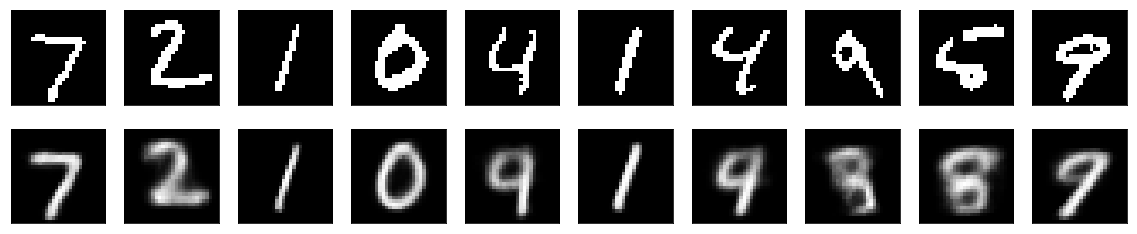

In [49]:
decoded_imgs = autoencoder.predict(test_images_flatten)

n = 10 # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images_flatten[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### visualize latent_space

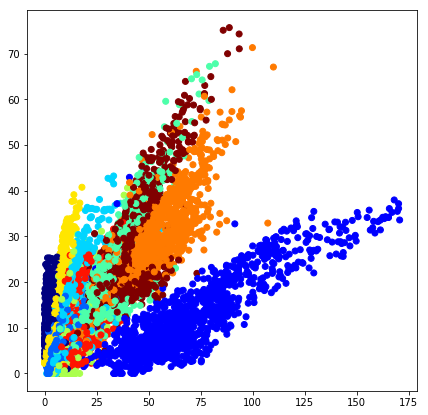

In [50]:
##試著調調看 latent space 試試

latent_space = tf.keras.Model(inputs = autoencoder.input, outputs = autoencoder.get_layer("latent_space").output)

latent_z = latent_space.predict(test_images_flatten)
encodings= np.asarray(latent_z)
encodings = encodings.reshape(test_images_flatten.shape[0], 2)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=test_label, cmap=plt.cm.jet)
plt.show()

## conv_AE

In [12]:
input_img = tf.keras.layers.Input(shape = (28, 28, 1))

encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name="latent_space")(encoder)


decoder = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(decoder)


conv_autoencoder = tf.keras.models.Model(input_img, decoder)
conv_autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

conv_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
latent_space (MaxPooling2D)  (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 8)         0         
__________

In [13]:
conv_autoencoder.fit(train_images, train_images, epochs=100, batch_size=128, shuffle=True,
                validation_data=(test_images, test_images), verbose = 2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 5s - loss: 0.1296 - val_loss: 0.0550
Epoch 2/100
 - 4s - loss: 0.0484 - val_loss: 0.0419
Epoch 3/100
 - 4s - loss: 0.0396 - val_loss: 0.0361
Epoch 4/100
 - 4s - loss: 0.0351 - val_loss: 0.0328
Epoch 5/100
 - 4s - loss: 0.0322 - val_loss: 0.0304
Epoch 6/100
 - 4s - loss: 0.0300 - val_loss: 0.0285
Epoch 7/100
 - 4s - loss: 0.0282 - val_loss: 0.0269
Epoch 8/100
 - 4s - loss: 0.0268 - val_loss: 0.0255
Epoch 9/100
 - 4s - loss: 0.0255 - val_loss: 0.0245
Epoch 10/100
 - 4s - loss: 0.0245 - val_loss: 0.0234
Epoch 11/100
 - 4s - loss: 0.0236 - val_loss: 0.0227
Epoch 12/100
 - 4s - loss: 0.0229 - val_loss: 0.0221
Epoch 13/100
 - 4s - loss: 0.0223 - val_loss: 0.0216
Epoch 14/100
 - 4s - loss: 0.0219 - val_loss: 0.0215
Epoch 15/100
 - 4s - loss: 0.0215 - val_loss: 0.0207
Epoch 16/100
 - 4s - loss: 0.0211 - val_loss: 0.0209
Epoch 17/100
 - 4s - loss: 0.0208 - val_loss: 0.0201
Epoch 18/100
 - 4s - loss: 0.0205 - val_loss: 0.0199
Epoch

KeyboardInterrupt: 

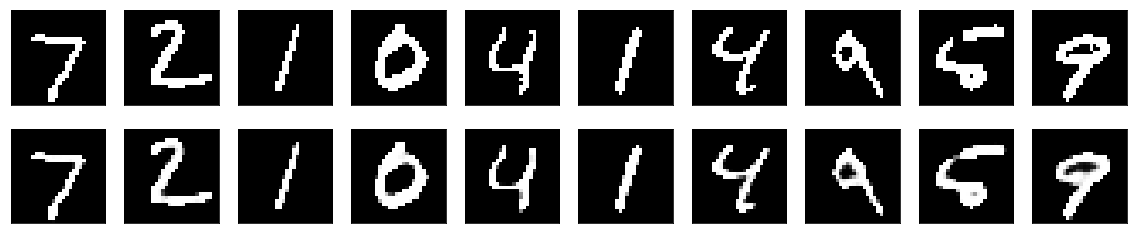

In [14]:
decoded_imgs = conv_autoencoder.predict(test_images)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [35]:
X[:,0]

(10000, 2)

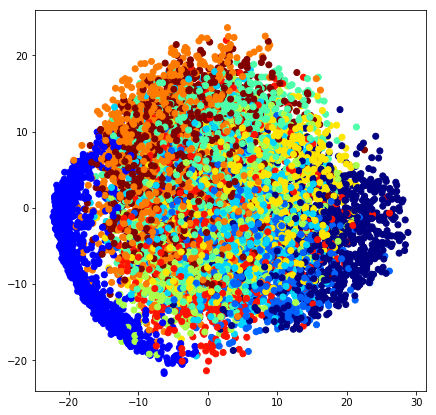

In [38]:
latent_space = tf.keras.Model(inputs = conv_autoencoder.input, outputs = conv_autoencoder.get_layer("latent_space").output)

latent_z = latent_space.predict(test_images)
encodings= np.asarray(latent_z)
encodings = encodings.reshape(encodings.shape[0], -1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(encodings)
Y = test_label

plt.figure(figsize=(7, 7))
plt.scatter(X[:,0], X[:,1], c= test_label, cmap=plt.cm.jet)
plt.show()

In [62]:
X[:0].shape

(0, 3)

In [91]:
# !pip install plotly

In [90]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np


# x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(10), 400).transpose()
X[:,0], X[:,1], X[:,2]
trace1 = go.Scatter3d(
    x=X[:,0][:1000],
    y=X[:,1][:1000],
    z=X[:,2][:1000],
    mode='markers',
    marker=dict(
        size=12,
        color = test_label,                # set color to an array/list of desired values
        colorscale='Rainbow',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig)

'file:///home/jovyan/playGround/Medium/201901_AE/temp-plot.html'

## image denoising AE

In [98]:
(train_images, train_label), (test_images, test_label) = tf.keras.datasets.fashion_mnist.load_data()

#normalize data
train_images = train_images/255.
train_images = np.reshape(train_images, (len(train_images),28,28,1))
train_images_flatten = train_images.reshape(train_images.shape[0],-1)

test_images = test_images/255.
test_images = np.reshape(test_images, (len(test_images),28,28,1))
test_images_flatten = test_images.reshape(test_images.shape[0],-1)


#先block住不知道要幹嘛的
# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [99]:
noise = 0.2
train_images_noise = train_images + noise + np.random.normal(loc = 0.0, scale = 0.2, size=train_images.shape)
test_images_noise = test_images + noise + np.random.normal(loc = 0.0, scale = 0.2, size=test_images.shape)

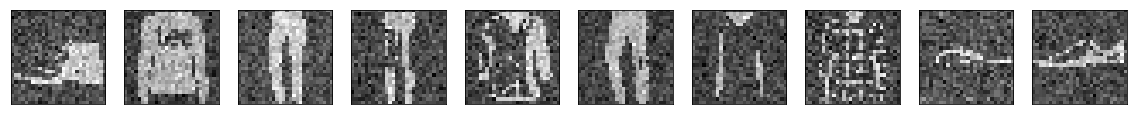

In [100]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_images_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [101]:
train_images_noise = np.clip(train_images_noise, 0., 1.)
test_images_noise = np.clip(test_images_noise, 0., 1.)

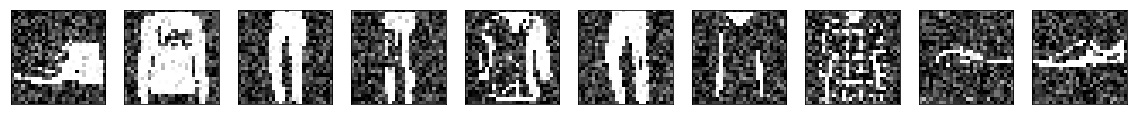

In [102]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_images_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [103]:
input_img = tf.keras.layers.Input(shape = (28, 28, 1))

encoder = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)


decoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(decoder)


denoise_autoencoder = tf.keras.models.Model(input_img, decoder)
denoise_autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

denoise_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 64)        0         
__________

In [ ]:
denoise_autoencoder.fit(train_images_noise, train_images, epochs=100, batch_size=128, shuffle=True,
                validation_data=(test_images_noise, test_images), verbose = 2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 5s - loss: 0.1545 - val_loss: 0.1097
Epoch 2/100
 - 4s - loss: 0.0966 - val_loss: 0.0874
Epoch 3/100
 - 5s - loss: 0.0772 - val_loss: 0.0692
Epoch 4/100
 - 4s - loss: 0.0628 - val_loss: 0.0583
Epoch 5/100
 - 4s - loss: 0.0543 - val_loss: 0.0516
Epoch 6/100
 - 4s - loss: 0.0486 - val_loss: 0.0471
Epoch 7/100
 - 4s - loss: 0.0443 - val_loss: 0.0432
Epoch 8/100
 - 4s - loss: 0.0408 - val_loss: 0.0396
Epoch 9/100
 - 4s - loss: 0.0379 - val_loss: 0.0372
Epoch 10/100
 - 4s - loss: 0.0355 - val_loss: 0.0348
Epoch 11/100
 - 4s - loss: 0.0332 - val_loss: 0.0326
Epoch 12/100
 - 4s - loss: 0.0312 - val_loss: 0.0308
Epoch 13/100


In [ ]:
decoded_imgs = denoise_autoencoder.predict(test_images_noise)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()